## Get data

The first step is to get the data from the API and the PDF.

- GET https://af-cargo-api-cargo.azuremicroservices.io/api/compartment to retrieve all compartments
- GET https://af-cargo-api-cargo.azuremicroservices.io/api/container to retrieve all container types
- GET https://af-cargo-api-cargo.azuremicroservices.io/api/shipment to retrieve all shipments
- GET https://af-cargo-api-cargo.azuremicroservices.io/api/luggage to retrieve nb of Luggage and average weight
- POST https://af-cargo-api-cargo.azuremicroservices.io/api/submit to submit your answer with an object containing the 5 compartment with their containers and shipments (shipment id list).
- POST http://localhost:8081/api/graph to transform the solution into the image (base64 encoded)


### Load data from the PDF as static values

In [1]:
DEFAULT_LUGGAGE_CONTAINER = 'AKE'
DEFAULT_NB_LUGGAGE_PER_CONTAINER = 38
DEFAULT_CONTAINER_TARE_WEIGHT = {
    "PMC": 120,
    "PAG": 125,
    "AKE": 57,
}

DEFAULT_CONTAINER_MAX_WEIGHT = {
    "PMC": 5102,
    "PAG": 4676,
    "AKE": 1587,
}

DEFAULT_COMPARTMENTS_MAX_WEIGHT = {
    "FWD": 32005,
    "AFT": 25655,
}

DEFAULT_MAX_CONTAINERS_BY_COMPARTMENT = {
    1: [{
        "PMC": 3,
        "PAG": 0,
        "AKE": 2
    },
        {
            "PMC": 2,
            "PAG": 0,
            "AKE": 2
        },
        {
            "PMC": 1,
            "PAG": 0,
            "AKE": 6
        },
        {
            "PMC": 0,
            "PAG": 0,
            "AKE": 10
        }
    ],
    2: [{
        "PMC": 3,
        "PAG": 0,
        "AKE": 0
    },
        {
            "PMC": 2,
            "PAG": 0,
            "AKE": 2
        },
        {
            "PMC": 1,
            "PAG": 1,
            "AKE": 4
        }],
    3: [{
        "PMC": 3,
        "PAG": 0,
        "AKE": 0
    },
        {
            "PMC": 2,
            "PAG": 0,
            "AKE": 0
        },
        {
            "PMC": 1,
            "PAG": 1,
            "AKE": 2
        }],
    4: [{
        "PMC": 2,
        "PAG": 0,
        "AKE": 0
    },
        {
            "PMC": 1,
            "PAG": 0,
            "AKE": 4
        },
        {
            "PMC": 0,
            "PAG": 0,
            "AKE": 8
        }],
}



### Create classes for the data
To be able to act upon the data. We need to create classes for each type


In [2]:

class Shipment:
    """Rectangle Shipment class."""

    def __init__(self, weight: float, height, width, length, awb, id=1):
        self.awb = awb
        self.weight = weight
        self.awb = awb
        self.width = width
        self.height = height
        self.length = length
        self.volume = self.width * self.height * self.length
        self.density = self.weight / self.volume
        self._id = id

    def __str__(self):
        return f'Shipment({self._id} , {self.awb}, {self.weight}, {self.width}, {self.height}, {self.length}, {self.volume}, {self.density})'


class ContainerType:
    container_type_id = 0

    def __init__(self, container_type, height, width, length, max_weight, tare_weight):
        Container.container_id += 1
        self.container_type_id = Container.container_id
        self.container_type = container_type
        self.height = height
        self.width = width
        self.length = length
        self.volume = self.width * self.height * self.length
        self.max_weight = max_weight
        self.tare_weight = 0

    def __str__(self):
        return f'ContainerType({self.container_type}, {self.height}, {self.width}, {self.length})'


class Compartment:
    def __init__(self, compartment_id, max_weight):
        self.compartment_id = compartment_id
        # self.height = height
        # self.width = width
        # self.length = length
        self.containers = []
        self.max_weight = max_weight
        self.weight = 0

    def add_container(self, container):
        self.containers.append(container)
        self.weight += container.weight

    def __str__(self):
        return f'Compartment({self.compartment_id}, {self.max_weight}, {self.containers})'


class Container:
    container_id = 0

    def __init__(self, container_type: ContainerType, is_required=False):
        Container.container_id += 1
        self.container_id = Container.container_id
        self.container_type = container_type
        self.shipments = []
        self.occupied_volume = 0
        self.weight = container_type.tare_weight
        self.occupied_volume_percentage = 0
        self.is_required = is_required
        self.density = 0

    def add_shipment(self, shipment: Shipment):
        self.shipments.append(shipment)
        self.occupied_volume += shipment.volume
        self.weight += shipment.weight
        self.occupied_volume_percentage = self.occupied_volume / self.container_type.volume
        self.density = self.weight / self.container_type.volume

    def full_luggage(self):
        return self.occupied_volume_percentage == 1

    def __str__(self):
        return f'Container({self.container_id} , {self.is_required=}, {self.density=}, {self.container_type=}, {self.weight=}, {self.occupied_volume_percentage=}, {self.occupied_volume=})'


class LotOfLuggage:  # class for the luggage, a type of shipment

    def __init__(self, first_class_luggage, nb_luggage, avg_weight, container_type, number_of_luggage_by_container):
        self.number_of_luggage_per_container = number_of_luggage_by_container
        self.avg_weight = avg_weight
        self.container_type = container_type
        self.containers = LotOfLuggage.split_luggage_into_containers(
            nb_luggage - first_class_luggage, avg_weight, container_type, number_of_luggage_by_container
        ) + LotOfLuggage.split_luggage_into_containers(
            first_class_luggage, avg_weight, container_type, number_of_luggage_by_container
        )
        self.total_weight = sum([container.weight for container in self.containers])

    @staticmethod
    def split_luggage_into_containers(nb_luggage, avg_weight, container_type, number_of_luggage_by_container):
        number_of_containers = int(nb_luggage / number_of_luggage_by_container)
        remaining_luggage = nb_luggage % number_of_luggage_by_container
        containers = []
        for _ in range(number_of_containers):
            container = Container(container_type, is_required=True)
            container.weight = avg_weight * number_of_luggage_by_container
            container.occupied_volume = container.container_type.volume
            container.occupied_volume_percentage = 1
            container.density = container.weight / container.container_type.volume
            container.nb_luggage = number_of_luggage_by_container
            containers.append(container)
        if remaining_luggage > 0:
            container = Container(container_type)
            container.weight = avg_weight * remaining_luggage
            container.occupied_volume = container.container_type.volume * (
                    remaining_luggage / number_of_luggage_by_container)
            container.occupied_volume_percentage = container.occupied_volume / container.container_type.volume
            container.density = container.weight / container.container_type.volume
            container.nb_luggage = remaining_luggage
            containers.append(container)
        return containers



### Create functions to call the API

In [3]:

import base64
import requests


def get_compartments():
    """Get all compartments from API."""
    response = requests.get("https://af-cargo-api-cargo.azuremicroservices.io/api/compartment").json()
    return [Compartment(compartment["compartmentId"], compartment["maxWeight"]) for compartment in response]


def get_container_types():
    """Get all container types from API."""
    response = requests.get("https://af-cargo-api-cargo.azuremicroservices.io/api/container")
    return [ContainerType(container_type["type"],
                          container_type["height"],
                          container_type["width"],
                          container_type["length"],
                          DEFAULT_CONTAINER_MAX_WEIGHT[container_type["type"]],
                          DEFAULT_CONTAINER_TARE_WEIGHT[container_type["type"]])
            for container_type
            in response.json()]


def get_shipments():
    """Get all shipments from API."""
    response = requests.get("https://af-cargo-api-cargo.azuremicroservices.io/api/shipment")
    return [Shipment(shipment["weight"], shipment["height"], shipment["width"], shipment["length"], shipment["awb"],
                     shipment["id"]) for
            shipment in response.json()]


def get_luggage():
    """Get all shipments from API."""
    response = requests.get("https://af-cargo-api-cargo.azuremicroservices.io/api/luggage").json()
    return LotOfLuggage(response["nbFirstClassLuggage"], response["nbLuggage"], response["avgWeight"],
                        list(filter(lambda x: x.container_type == DEFAULT_LUGGAGE_CONTAINER, get_container_types()))[0],
                        DEFAULT_NB_LUGGAGE_PER_CONTAINER)


def submit_solution(solution):
    """Submit solution to API."""
    response = requests.post("https://af-cargo-api-cargo.azuremicroservices.io/api/submit", json=solution)
    return response.json()


def get_graph(solution):
    """Get graph from API as a base64 image and write it to output.png"""
    response = requests.post("http://localhost:8081/api/graph", json=solution)

    print(response.json())
    g = open("output.png", "wb")
    g.write(base64.b64decode(response.json()["graph.png"]))
    g.close()



## Algorithm

### Step 1: The first step of the algorithm is to get the data using the functions created before

In [4]:
# Get all shipments
shipments = get_shipments()
# Get all container types
container_types: [ContainerType] = get_container_types()

### Step 2: Shipment sorting
- To sort the shipments we first put each shipment into the smallest container type it will fit in
- Then we sort the shipment by density in each container type

In [5]:
from typing import List


def sort_shipments(_shipments: List[Shipment], _container_types: List[ContainerType]):
    """Sort shipments by size and density, to place them more effectively"""
    shipments_dict = {}

    container_types.sort(key=lambda x: x.height * x.width * x.length)
    # test if the shipments fit in the AKE, else, put them in PAG or PMC
    for shipment in _shipments:
        for container_type in _container_types:
            if shipment.width <= container_type.width and shipment.height <= container_type.height and shipment.length <= container_type.length and shipment.weight <= (
                    container_type.max_weight - container_type.tare_weight):
                if container_type in shipments_dict:
                    shipments_dict[container_type].append(shipment)
                else:
                    shipments_dict[container_type] = [shipment]
                break
    # sort shipments by density
    for container_type in shipments_dict:
        shipments_dict[container_type].sort(
            key=lambda _shipment: _shipment.density, reverse=True)

    return shipments_dict


sorted_shipments = sort_shipments(shipments, container_types)

### Step 3: Splitting the sorted shipments by containers
We now know which shipment will fit in each container type. As we sorted the shipments by density the step before it allows us to have a lot of variation in terms of density as we create the containers

In [6]:
VOLUME_MAX_PERCENTAGE = 0.9


def split_shipments_by_containers(_shipments: List[Shipment], _container_types: List[ContainerType]):
    """Split _shipments by container types."""
    shipments_dict = sort_shipments(_shipments, _container_types)
    container_dict = {}

    for container_type in shipments_dict:
        container_dict[container_type] = []
        current_container = Container(container_type)
        container_dict[container_type].append(current_container)
        for shipment in shipments_dict[container_type]:
            if current_container.occupied_volume + shipment.volume > container_type.volume * VOLUME_MAX_PERCENTAGE or current_container.weight + shipment.weight > container_type.max_weight:
                current_container = Container(container_type)
                current_container.add_shipment(shipment)
                container_dict[container_type].append(current_container)
            else:
                current_container.add_shipment(shipment)
    return container_dict


containers = split_shipments_by_containers(shipments, container_types)


### Step 4: Luggage Constraints
The luggage is mandatory. So we first check its density to see if we need to put the luggage in FWD or AFT. We also need to extract the heaviest luggage AKE to put in the 5th compartment

In [25]:
luggage = get_luggage()
luggage_weight = sum(map(lambda x: x.weight, luggage.containers))
# get the heaviest luggage container
heaviest_luggage_container = max(luggage.containers, key=lambda x: x.weight)
# remove the heaviest luggage container from the list
luggage.containers.remove(heaviest_luggage_container)

# check if the sum of the weight of number of luggage containers of the shipments containers
sum_of_the_weight_shipments = sum(map(lambda x: x.weight,
                                      sorted(shipments, key=lambda x: x.weight, reverse=True)[
                                      :len(luggage.containers) + 1]))
luggage_position = "FWD"
if sum_of_the_weight_shipments < luggage_weight:
    luggage_position = "AFT"


def get_compartment_position(_id):
    if _id >= 3:
        return "AFT"
    return "FWD"


#### Removing the possible combination of PMC, PAG, AKE
As the luggage is mandatory we need to remove the impossible combinations from the combination list and update the max weight of the compartments

In [8]:
container_combinations = {
    1: [],
    2: [],
    3: [],
    4: [],
}
luggage_containers_placed = 0
for combination_position in DEFAULT_MAX_CONTAINERS_BY_COMPARTMENT:
    if get_compartment_position(combination_position) == luggage_position:
        for combination in DEFAULT_MAX_CONTAINERS_BY_COMPARTMENT[combination_position]:
            combination["AKE"] -= len(luggage.containers)
            if combination["AKE"] >= 0:
                container_combinations[combination_position].append(combination)
    else:
        for combination in DEFAULT_CONTAINER_COMBINATIONS[combination_position]:
            container_combinations[combination_position].append(combination)

compartments_max_weight = {}

for compartment_position in DEFAULT_COMPARTMENTS_MAX_WEIGHT:
    if compartment_position == luggage_position:
        compartments_max_weight[compartment_position] = DEFAULT_COMPARTMENTS_MAX_WEIGHT[
                                                            compartment_position] - luggage.total_weight
    else:
        compartments_max_weight[compartment_position] = DEFAULT_COMPARTMENTS_MAX_WEIGHT[compartment_position]


NameError: name 'DEFAULT_CONTAINER_COMBINATIONS' is not defined

#

In [12]:
from typing import Dict
from tqdm import tqdm
import random


def find_best_container_combination(container_dict_copy: Dict[ContainerType, List[Container]],
                                    combinations: [Dict[str, int]],
                                    weight_target: float,
                                    number_of_tries: int):
    """Find the best container combination for a compartment_position."""

    def try_combination():
        _best_combination = None
        _curr_max = float('-inf')
        # find calculate the max weight of each combination
        for _combination in combinations:
            weight = 0
            current_containers = {}
            for _container_type in container_dict_copy.keys():
                if len(container_dict_copy[_container_type]) >= _combination[_container_type.container_type]:
                    sampled_containers = random.sample(container_dict_copy[_container_type],
                                                       _combination[_container_type.container_type])
                else:
                    sampled_containers = container_dict_copy[_container_type]
                weight += sum([_container.weight for _container in sampled_containers])
                current_containers[_container_type] = sampled_containers

            current_containers["max_weight"] = weight
            if weight_target > current_containers["max_weight"] > _curr_max:
                _curr_max = current_containers["max_weight"]
                _best_combination = current_containers
        return _best_combination

    # find the best combination closest to the target without exceeding it
    best_combination = None
    curr_max = float('-inf')
    for _ in range(number_of_tries):
        combination = try_combination()
        if combination:
            if curr_max < combination["max_weight"] <= weight_target:
                curr_max = combination["max_weight"]
                best_combination = combination
    containers_index = {}
    for container_type in best_combination:
        if container_type != "max_weight":
            containers_index[container_type] = []
            for container in best_combination[container_type]:
                containers_index[container_type].append(container_dict_copy[container_type].index(container))
    return best_combination, containers_index


In [14]:

result = find_best_container_combination(containers, DEFAULT_MAX_CONTAINERS_BY_COMPARTMENT[4], 16000,
                                         50000)
# print("Target weight: {}".format(compartments_max_weight["AFT"]))
print("AFT weight: {}".format(result[0]['max_weight']))


AFT weight: 12446.6


In [22]:
def split_containers_by_compartments(container_dict: Dict[ContainerType, List[Container]],
                                     compartments: List[Compartment],
                                     container_combinations: [Dict[str, List[Dict[str, int]]]],
                                     compartments_max_weight: Dict[str, float],
                                     number_of_tries):
    """Split containers by compartments."""
    compartments_dict = {}
    # sort compartments by compartment_id
    compartments.sort(key=lambda x: x.compartment_id, reverse=True)

    # # start filling compartments with the highest compartment_id
    # containers_combination_small, indexes = find_best_container_combination(container_dict,
    #                                                                         [{"AKE": 0, "PAG": 0, "PMC": 0}],
    #                                                                         2635)
    # copy the container_dict in order to not modify it
    container_dict_without_containers = {}
    for container_type in container_dict:
        container_dict_without_containers[container_type] = []
        for i, container in enumerate(container_dict[container_type]):
            container_dict_without_containers[container_type].append(container)

    containers_combination_1, indexes = find_best_container_combination(container_dict_without_containers,
                                                                        container_combinations[4],
                                                                        compartments[1].max_weight,
                                                                        number_of_tries)
    container_dict_without_containers2 = {}
    for container_type in container_dict_without_containers:
        container_dict_without_containers2[container_type] = []
        for i, container in enumerate(container_dict_without_containers[container_type]):
            if i not in indexes[container_type]:
                container_dict_without_containers2[container_type].append(container)
    containers_combination_2, indexes = find_best_container_combination(container_dict_without_containers2,
                                                                        container_combinations[3],
                                                                        compartments[2].max_weight,
                                                                        number_of_tries)
    container_dict_without_containers3 = {}
    for container_type in container_dict_without_containers2:
        container_dict_without_containers3[container_type] = []
        for i, container in enumerate(container_dict_without_containers2[container_type]):
            if i not in indexes[container_type]:
                container_dict_without_containers3[container_type].append(container)
    containers_combination_3, indexes = find_best_container_combination(container_dict_without_containers3,
                                                                        container_combinations[2],
                                                                        compartments[3].max_weight,
                                                                        number_of_tries)
    container_dict_without_containers4 = {}
    for container_type in container_dict_without_containers3:
        container_dict_without_containers4[container_type] = []
        for i, container in enumerate(container_dict_without_containers3[container_type]):
            if i not in indexes[container_type]:
                container_dict_without_containers4[container_type].append(container)
    containers_combination_4, indexes = find_best_container_combination(container_dict_without_containers4,
                                                                        container_combinations[3],
                                                                        compartments[4].max_weight,
                                                                        number_of_tries)

    return containers_combination_1, containers_combination_2, containers_combination_3, containers_combination_4, container_dict

Tests

In [24]:
split_containers_by_compartments(containers, get_compartments(), DEFAULT_MAX_CONTAINERS_BY_COMPARTMENT,
                                 DEFAULT_CONTAINER_MAX_WEIGHT, 100000)

({<__main__.ContainerType at 0x1ef76844490>: [<__main__.Container at 0x1ef76846e30>,
  <__main__.ContainerType at 0x1ef76845f90>: [],
  'max_weight': 10954.9},
 {<__main__.ContainerType at 0x1ef76844490>: [<__main__.Container at 0x1ef76a0f130>,
  <__main__.ContainerType at 0x1ef76845f90>: [<__main__.Container at 0x1ef76a0ee60>],
  'max_weight': 7616.4},
 {<__main__.ContainerType at 0x1ef76844490>: [<__main__.Container at 0x1ef76846b60>,
  <__main__.ContainerType at 0x1ef76845f90>: [<__main__.Container at 0x1ef76a0efb0>],
  'max_weight': 9560.0},
 {<__main__.ContainerType at 0x1ef76844490>: [<__main__.Container at 0x1ef76a0f5e0>,
  <__main__.ContainerType at 0x1ef76845f90>: [<__main__.Container at 0x1ef76844430>],
  'max_weight': 6440.0},
 {<__main__.ContainerType at 0x1ef76844490>: [<__main__.Container at 0x1ef768448b0>,
  <__main__.ContainerType at 0x1ef76845f90>: [<__main__.Container at 0x1ef76844430>,
   <__main__.Container at 0x1ef76a0f070>]})

blabla

In [13]:
import statistics
from matplotlib import pyplot as plt
import numpy as np

NUMBER_OF_SAMPLE = 50
x = []
y = []
y_best = []
y_error = []


def powspace(start: float, stop: float, num: int):
    log_start, log_stop = np.log(start), np.log(stop)
    return np.exp(np.linspace(log_start, log_stop, num))


for number_of_tries in tqdm(powspace(1, 10000, 70)):
    x.append(number_of_tries)
    values = []
    for k in range(NUMBER_OF_SAMPLE):
        values.append(
            find_best_container_combination(containers, container_combinations["AFT"], compartments_max_weight["AFT"],
                                            int(number_of_tries))[0]['max_weight'])

    y.append(statistics.mean(values))
    y_error.append(statistics.stdev(values))
    y_best.append(25655)


100%|██████████| 50/50 [05:10<00:00,  6.21s/it]


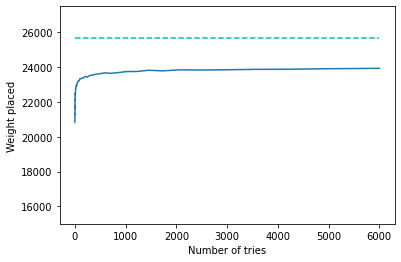

In [14]:
plt.plot(x, y)
plt.plot(x, y_best, "--c")
plt.xscale('log', base=2)
plt.ylim((15000, 27500))
plt.xlabel("Number of tries")
plt.ylabel("Weight placed")
plt.title("Algorithm precision")
plt.show()

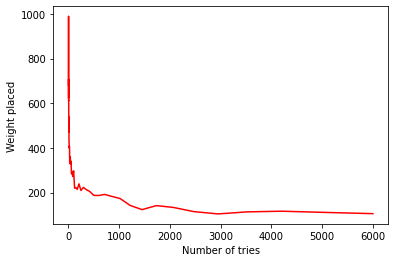

In [15]:
plt.plot(x, y_error, "red")
plt.xscale('log', base=2)
plt.xlabel("Number of tries")
plt.ylabel("Weight std div")
plt.title("Algorithm error")
plt.show()

Target weight: 25655
AFT weight: 24657.8
